# 1. Importación y configuración de entorno

## Variables de entorno

In [ ]:
# Directorio del dataset único: 
# Se asume que este directorio contiene carpetas, cada una con imágenes de una clase.
dataset_dir = r'.\archive'

## Carga librerías

In [7]:
# Importamos las librerías esenciales de PyTorch y otras utilidades
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models

import time
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize

## Selección de dispositivo

In [8]:
# Configuramos el dispositivo: usamos GPU si está disponible, sino se utiliza la CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", device)

Usando dispositivo: cuda:0


## Semilla de reproducibilidad

In [9]:
# Establecemos una semilla para garantizar la reproducibilidad de los experimentos
seed = 42
random.seed(seed)
torch.manual_seed(seed)
if device.type == 'cuda':
    torch.cuda.manual_seed(seed)

## Definición de hiperparámetros

In [10]:
# Hiperparámetros iniciales
BATCH_SIZE = 32      # Tamaño del batch para el entrenamiento
NUM_EPOCHS = 10      # Número de épocas (iteraciones completas sobre el dataset)
LEARNING_RATE = 1e-3 # Tasa de aprendizaje inicial
TRAIN_RATIO = 0.8    # Porcentaje de datos para entrenamiento (80% train, 20% valid)

## Carga de dataset

In [12]:
# Mostramos la estructura del dataset (lista de clases) para verificar la organización
dataset_full = datasets.ImageFolder(root=dataset_dir, transform=transforms.ToTensor())
print("Clases encontradas en el dataset:", dataset_full.classes)

Clases encontradas en el dataset: ['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


# 2. Transformaciones, Preprocesamiento y Data Augmentation

In [13]:
# Definimos las transformaciones para el conjunto de entrenamiento
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),                   # Redimensiona todas las imágenes a 224x224 píxeles, requisito para MobileNetV2.
    transforms.RandomHorizontalFlip(p=0.5),          # Aplica un volteo horizontal aleatorio, lo que incrementa la variabilidad de los datos.
    transforms.RandomRotation(degrees=15),           # Aplica una rotación aleatoria de la imagen dentro de un rango de 15 grados.
    transforms.ToTensor(),                           # Convierte la imagen de PIL a tensor, normalizando los píxeles a un rango entre 0 y 1.
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # Normaliza la imagen utilizando las medias y desviaciones estándar de ImageNet.
                         std=[0.229, 0.224, 0.225])  # Esto es importante para que las imágenes sean compatibles con el modelo preentrenado.
]) 

# Definimos las transformaciones para el conjunto de validación
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # Redimensiona las imágenes a 224x224 píxeles (sin data augmentation extra)
    transforms.ToTensor(), # Convierte la imagen a tensor.
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # Normaliza la imagen con los parámetros de ImageNet para mantener la consistencia.
                         std=[0.229, 0.224, 0.225])
])

# 3. División del dataset

# Cargas el dataset completo sin transform

In [14]:
# Cargar el dataset completo (sin aplicar transformaciones aquí).
full_dataset = datasets.ImageFolder(
    root=dataset_dir, 
    transform=None  # Se aplicará transform más adelante según el subset (train/val).
)

# División del dataset en entrenamiento y validación

In [15]:
# Cálculo del número total de muestras y división en proporciones (p.ej., 80/20).
dataset_size = len(full_dataset)
train_size = int(TRAIN_RATIO * dataset_size)
val_size = dataset_size - train_size

# Dividimos el dataset con random_split (usando la semilla para reproducibilidad).
train_dataset, val_dataset = random_split(
    full_dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(seed)
)

print(f"Total de imágenes: {dataset_size}  ->  Train: {train_size}, Validation: {val_size}")

Total de imágenes: 31002  ->  Train: 24801, Validation: 6201


In [16]:
# Asignamos transformaciones a cada subset según corresponda (esto para evitar errores al lanzar el modelo con el random)
# (train_transforms y val_transforms se definieron en el Paso 2).
train_dataset.dataset.transform = train_transforms
val_dataset.dataset.transform   = val_transforms

Con este ajuste, todas las imágenes del conjunto de entrenamiento y validación se redimensionarán a 224×224, evitando el problema de dimensiones distintas que causaba el error al hacer batching.

# Creación de dataloaders

In [17]:
# Creamos DataLoaders para entrenar y validar
# Notar que no se especifica 'shuffle' en el conjunto de validación.
train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=2
)
val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=2
)

# Confirmamos la detección de clases en el dataset completo.
print("Clases detectadas en el dataset (orden interno):", full_dataset.classes)

Clases detectadas en el dataset (orden interno): ['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


# 4. Modelo Preentrenado y Congelación de Capas

Este bloque de código se encargará de cargar MobileNetV2 con pesos preentrenados en ImageNet, enviar el modelo al dispositivo (CPU o GPU) y congelar sus capas base para que, en el entrenamiento inicial, solo se actualicen las nuevas capas que añadiremos posteriormente (en el siguiente bloque).

In [18]:
# Importamos el modelo MobileNetV2 desde torchvision.models.
# En versiones recientes de PyTorch se recomienda utilizar el argumento 'weights'
# para indicar que se carguen los pesos preentrenados de ImageNet.
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights

# Cargamos el modelo con los pesos preentrenados.
# Esto asegura que el modelo ya tiene conocimientos generales de características visuales.
model = mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V1)

# Enviamos el modelo al dispositivo definido (GPU si está disponible, de lo contrario CPU)
model = model.to(device)

# Congelamos todas las capas base para que sus pesos no sean actualizados durante el entrenamiento inicial.
# Esto significa que, en este primer paso de transfer learning, solo se entrenará la nueva capa de clasificación.
for param in model.parameters():
    param.requires_grad = False

print("MobileNetV2 cargado y capas base congeladas.")

MobileNetV2 cargado y capas base congeladas.


In [19]:
print(model)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

# 5. Reemplazo capa final

La capa final de MobileNetV2 es parte de 'model.classifier'. 
Normalmente, esta parte consta de un Dropout, y una capa lineal. Necesitamos modificar la capa lineal para que tenga NUM_CLASSES salidas.

In [20]:
# Número de clases: ['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
NUM_CLASSES = 8  

# Extraemos el número de características de entrada de la última capa original.
in_features = model.classifier[1].in_features

# Reemplazamos la última capa (la capa de clasificación) con una nueva capa lineal que tenga la salida adecuada.
model.classifier[1] = torch.nn.Linear(in_features, NUM_CLASSES)

# Una vez reemplazada la capa, aseguramos que el modelo se envíe al dispositivo (CPU o GPU)
model = model.to(device)

# Imprimimos la parte modificada para verificar que la nueva capa se ha incorporado correctamente.
print("Estructura de la parte final del modelo modificada:")
print(model.classifier)

Estructura de la parte final del modelo modificada:
Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=8, bias=True)
)


# 6. Definición de pérdida y Optimizador

In [21]:

# Se define la función de pérdida para un problema de clasificación multiclase.
# CrossEntropyLoss combina log_softmax y la pérdida de entropía cruzada, lo que es ideal para este tipo de problemas.
criterion = nn.CrossEntropyLoss()

# Configuramos el optimizador; en este caso utilizamos Adam.
# Como estamos en la etapa inicial de transfer learning y solo queremos actualizar la nueva capa de clasificación,
# se pasan como parámetros únicamente los que pertenecen a model.classifier[1].
optimizer = optim.Adam(model.classifier[1].parameters(), lr=LEARNING_RATE)

print("Función de pérdida y optimizador configurados correctamente.")

Función de pérdida y optimizador configurados correctamente.


# 7. Entrenamiento Inicial (Frozen)

In [22]:
# Definimos las funciones de entrenamiento y validación
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Forward
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == targets).sum().item()
        total += targets.size(0)
        
    epoch_loss = running_loss / total
    epoch_acc = 100.0 * correct / total
    return epoch_loss, epoch_acc

def validate_one_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == targets).sum().item()
            total += targets.size(0)
    
    epoch_loss = running_loss / total
    epoch_acc = 100.0 * correct / total
    return epoch_loss, epoch_acc

In [23]:
# Inicializamos listas para almacenar la evolución de Loss y Accuracy en entrenamiento y validación
train_loss_history = []
train_acc_history = []
val_loss_history   = []
val_acc_history    = []

# Inicializamos la mejor pérdida en infinito (o, si prefieres, la mejor exactitud en 0)
best_val_loss = float('inf')
PATH_BEST_FROZEN = "best_model_frozen_affectnet_v1.pt"

# (Opcional) Parámetro para early stopping: definir la "paciencia" en número de épocas sin mejora
patience = 5   # Por ejemplo, si no mejora en 5 épocas se detiene
epochs_no_improve = 0

print("Inicio del entrenamiento (fase Frozen):")
for epoch in range(NUM_EPOCHS):
    # Entrenamiento en la época actual
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    # Evaluación en el conjunto de validación
    val_loss, val_acc = validate_one_epoch(model, val_loader, criterion, device)
    
    # Almacenamos las métricas para graficar luego
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)
    
    # Imprime resultados de la época
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}: "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% || "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    
    # Guardar el mejor modelo según la métrica de pérdida de validación
    if val_loss < best_val_loss:
    #if val_acc > best_val_acc:    # Si preferimos basarnos en la precisión (val_acc)
        best_val_loss = val_loss
        torch.save(model.state_dict(), PATH_BEST_FROZEN)
        print(f">>> Modelo (Frozen) guardado en la época {epoch+1} con Val Loss = {val_loss:.4f}")
        epochs_no_improve = 0  # Reseteamos el contador ya que hay mejora
    else:
        epochs_no_improve += 1
        
    # (Opcional) Implementación de Early Stopping: salir del bucle si no hay mejora tras 'patience' épocas
    if epochs_no_improve >= patience:
        print("Early stopping activado. Finalizando el entrenamiento.")
        break


Inicio del entrenamiento (fase Frozen):
Epoch 1/10: Train Loss: 1.5527, Train Acc: 40.95% || Val Loss: 1.4362, Val Acc: 45.09%
>>> Modelo (Frozen) guardado en la época 1 con Val Loss = 1.4362
Epoch 2/10: Train Loss: 1.4423, Train Acc: 45.84% || Val Loss: 1.4838, Val Acc: 44.07%
Epoch 3/10: Train Loss: 1.4152, Train Acc: 46.71% || Val Loss: 1.4238, Val Acc: 46.77%
>>> Modelo (Frozen) guardado en la época 3 con Val Loss = 1.4238
Epoch 4/10: Train Loss: 1.4070, Train Acc: 47.09% || Val Loss: 1.4355, Val Acc: 46.14%
Epoch 5/10: Train Loss: 1.4138, Train Acc: 46.96% || Val Loss: 1.3510, Val Acc: 49.07%
>>> Modelo (Frozen) guardado en la época 5 con Val Loss = 1.3510
Epoch 6/10: Train Loss: 1.4035, Train Acc: 47.29% || Val Loss: 1.3536, Val Acc: 48.96%
Epoch 7/10: Train Loss: 1.4101, Train Acc: 47.01% || Val Loss: 1.3689, Val Acc: 46.80%
Epoch 8/10: Train Loss: 1.4041, Train Acc: 47.72% || Val Loss: 1.3424, Val Acc: 49.10%
>>> Modelo (Frozen) guardado en la época 8 con Val Loss = 1.3424
Epoc

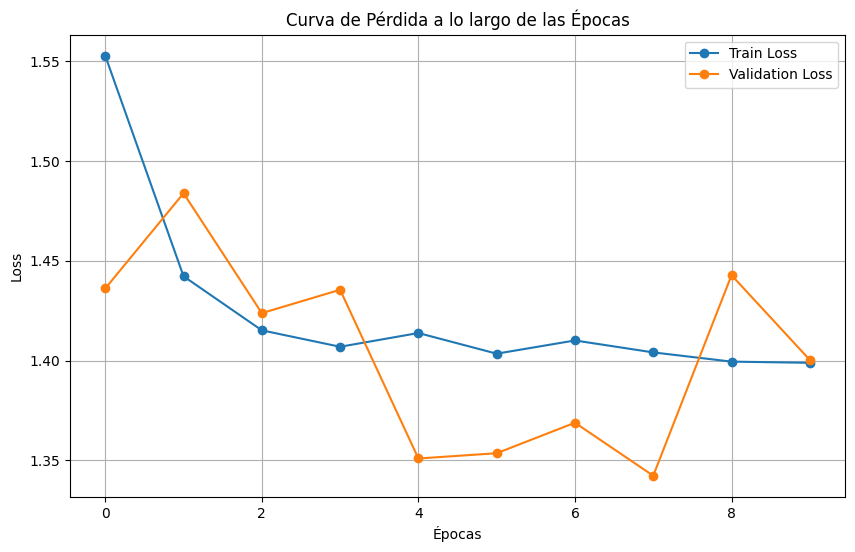

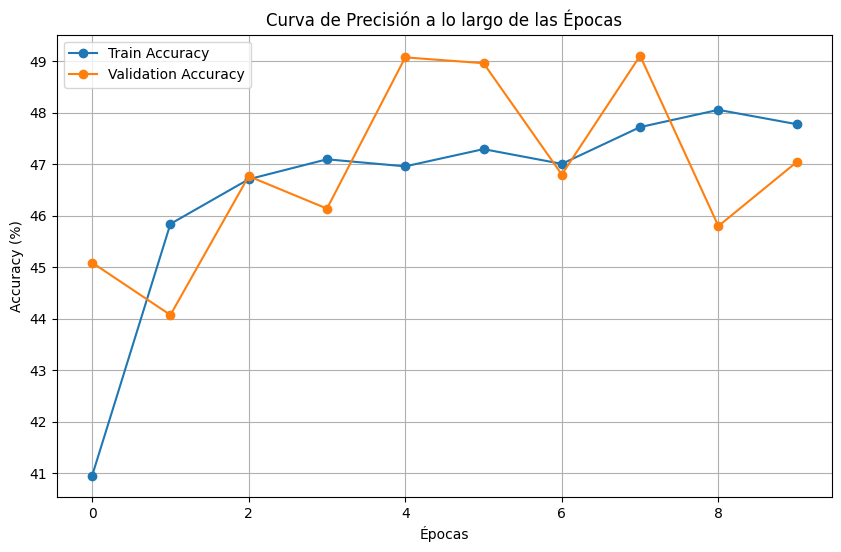

In [24]:
# Graficar la Loss Curve (Pérdida) para entrenamiento y validación
plt.figure(figsize=(10, 6))
plt.plot(train_loss_history, label='Train Loss', marker='o')
plt.plot(val_loss_history, label='Validation Loss', marker='o')
plt.title('Curva de Pérdida a lo largo de las Épocas')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Graficar la Accuracy Curve (Precisión) para entrenamiento y validación
plt.figure(figsize=(10, 6))
plt.plot(train_acc_history, label='Train Accuracy', marker='o')
plt.plot(val_acc_history, label='Validation Accuracy', marker='o')
plt.title('Curva de Precisión a lo largo de las Épocas')
plt.xlabel('Épocas')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

## Evaluación y Métricas Adicionales (modelo frozen)

Tiempo total de inferencia: 54.32 segundos
Tiempo promedio por imagen: 0.0088 segundos


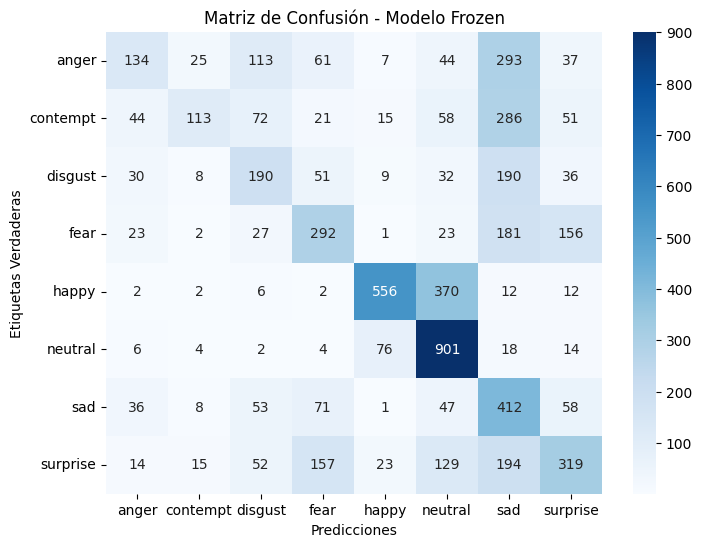

Reporte de Clasificación - Modelo Frozen:

              precision    recall  f1-score   support

       anger       0.46      0.19      0.27       714
    contempt       0.64      0.17      0.27       660
     disgust       0.37      0.35      0.36       546
        fear       0.44      0.41      0.43       705
       happy       0.81      0.58      0.67       962
     neutral       0.56      0.88      0.69      1025
         sad       0.26      0.60      0.36       686
    surprise       0.47      0.35      0.40       903

    accuracy                           0.47      6201
   macro avg       0.50      0.44      0.43      6201
weighted avg       0.52      0.47      0.46      6201



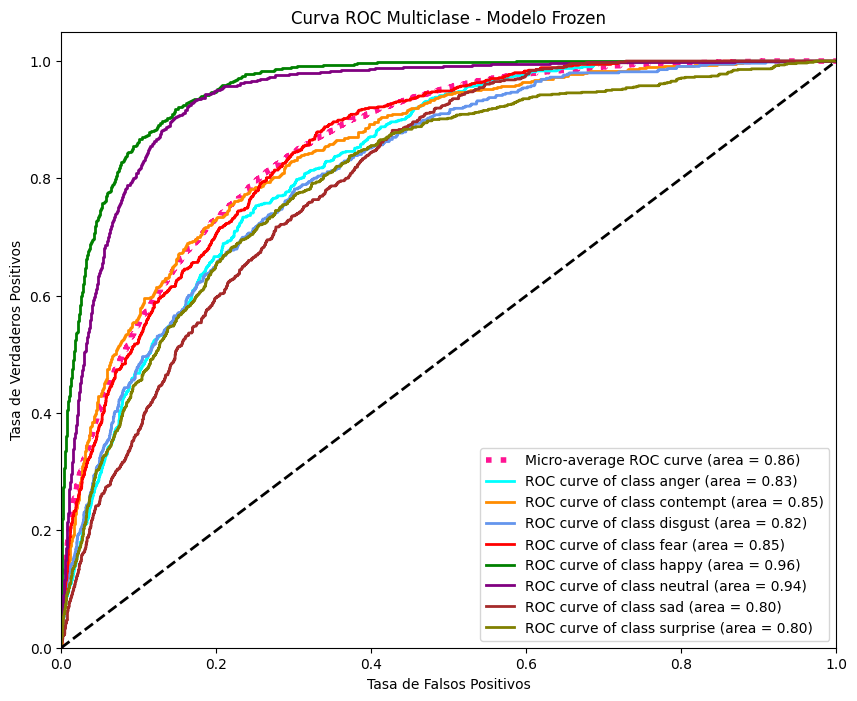

In [25]:
# Colocamos el modelo en modo evaluación (fase Frozen)
model.eval()

# Acumulamos predicciones y etiquetas verdaderas del conjunto de validación
all_preds = []
all_targets = []
all_probs = []  # Para la curva ROC

# Iniciamos el temporizador para medir el tiempo de inferencia
start_time = time.time()
with torch.no_grad():
    for inputs, targets in val_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        probs = torch.nn.functional.softmax(outputs, dim=1)  # Probabilidades
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
# end time
end_time = time.time()
# Imprimimos el tiempo total de inferencia y el tempo promedio por imagen
print(f"Tiempo total de inferencia: {end_time - start_time:.2f} segundos")
print(f"Tiempo promedio por imagen: {(end_time - start_time) / len(val_loader.dataset):.4f} segundos")
# Matriz de Confusión
cm = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=full_dataset.classes, yticklabels=full_dataset.classes)
plt.xlabel("Predicciones")
plt.ylabel("Etiquetas Verdaderas")
plt.title("Matriz de Confusión - Modelo Frozen")
plt.show()

# Reporte de Clasificación
print("Reporte de Clasificación - Modelo Frozen:\n")
print(classification_report(all_targets, all_preds, target_names=full_dataset.classes))

# Opcional: Curva ROC Multiclase para Modelo Frozen
all_probs = np.array(all_probs)      # Formato: [N, NUM_CLASSES]
all_targets = np.array(all_targets)  # Formato: [N]
y_true_bin = label_binarize(all_targets, classes=range(NUM_CLASSES))
n_classes = NUM_CLASSES

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), all_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure(figsize=(10,8))
plt.plot(fpr["micro"], tpr["micro"],
         label='Micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)
colors = ['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'purple', 'brown', 'olive', 'cyan']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(full_dataset.classes[i], roc_auc[i]))
plt.plot([0,1], [0,1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC Multiclase - Modelo Frozen')
plt.legend(loc="lower right")
plt.show()


# 8. Fine-Tuning (Descongelar Capas Seleccionadas)

1. Descongelar Capas Seleccionadas:

- Recorremos las últimas 3 capas dentro de model.features utilizando for param in model.features[-3:].parameters(): y establecemos param.requires_grad = True. Esto permite que, durante el fine-tuning, los pesos de estas capas se ajusten a tu dataset.

- Imprimimos un mensaje para confirmar que se han descongelado las capas.

2. reación de Optimizer para Fine-Tuning:

- Recorremos todos los parámetros de model y agregamos aquellos que tienen requires_grad = True a la lista params_to_update.

- Creamos un nuevo optimizador (en este caso, Adam) con un learning rate reducido (1e-4) para realizar el ajuste fino. Un learning rate menor suele ser recomendable en esta fase para no alterar bruscamente los pesos preentrenados.

3. Bucle de Fine-Tuning:

- Definimos cuántas épocas realizaremos en esta fase de fine-tuning (en el ejemplo, 5 épocas).

- Dentro del bucle de fine-tuning, se utilizan las funciones train_one_epoch y validate_one_epoch (ya definidas) para actualizar el modelo y evaluar su rendimiento.

- Se imprime la pérdida y precisión en cada época para monitorear la mejora del modelo.

In [26]:
# --------------------------------------------
# Fase Fine-Tuning: Descongelado de capas, entrenamiento y guardado del mejor modelo
# --------------------------------------------

# Descongelamos las últimas 3 capas del bloque de features de MobileNetV2 para fine-tuning.
for param in model.features[-3:].parameters():
    param.requires_grad = True
print("Las últimas 3 capas de model.features se han descongelado para fine-tuning.")

# Creamos un optimizador nuevo que actualice sólo los parámetros que tienen requires_grad=True,
# es decir, la nueva capa de clasificación y las capas recientemente descongeladas.
params_to_update = [param for name, param in model.named_parameters() if param.requires_grad]
fine_tune_optimizer = optim.Adam(params_to_update, lr=1e-4)  # Learning rate menor para fine-tuning

# Definimos el número de épocas para el fine-tuning
FINE_TUNE_EPOCHS = 10

# 4. Inicializamos listas para almacenar la evolución de loss y accuracy durante fine-tuning.
ft_train_loss_history = []
ft_train_acc_history = []
ft_val_loss_history   = []
ft_val_acc_history    = []

# Inicializamos el criterio para guardar el mejor modelo según la precisión de validación
best_val_acc = 0.0
PATH_BEST_FINE_TUNE = "best_model_finetuned_affectnet_v1.pt"

# (Opcional) Parámetros para early stopping en fine-tuning:
patience = 5       # Número de épocas sin mejora antes de detener el fine-tuning
epochs_no_improve = 0

print("Inicio del Fine-Tuning:")
for epoch in range(FINE_TUNE_EPOCHS):
    # Entrenamiento en la época actual usando el optimizador de fine-tuning.
    train_loss, train_acc = train_one_epoch(model, train_loader, fine_tune_optimizer, criterion, device)
    # Evaluación en el conjunto de validación.
    val_loss, val_acc = validate_one_epoch(model, val_loader, criterion, device)
    
    # Almacenamos las métricas de la época para futuras gráficas.
    ft_train_loss_history.append(train_loss)
    ft_train_acc_history.append(train_acc)
    ft_val_loss_history.append(val_loss)
    ft_val_acc_history.append(val_acc)
    
    print(f"Fine-Tuning Epoch {epoch+1}/{FINE_TUNE_EPOCHS}: "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% || "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    
    # Guardamos el modelo si la precisión de validación mejora.
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), PATH_BEST_FINE_TUNE)
        print(f">>> Modelo (Fine-Tuning) guardado en la época {epoch+1} con Val Acc = {val_acc:.2f}%")
        epochs_no_improve = 0  # Reseteamos el contador ya que hubo mejora.
    else:
        epochs_no_improve += 1
    
    # (Opcional) Early Stopping: se finaliza el fine-tuning si no mejora la precisión de validación tras 'patience' épocas.
    if epochs_no_improve >= patience:
        print("Early stopping activado en Fine-Tuning. Finalizando entrenamiento.")
        break

Las últimas 3 capas de model.features se han descongelado para fine-tuning.
Inicio del Fine-Tuning:
Fine-Tuning Epoch 1/10: Train Loss: 1.2300, Train Acc: 54.27% || Val Loss: 1.1123, Val Acc: 57.94%
>>> Modelo (Fine-Tuning) guardado en la época 1 con Val Acc = 57.94%
Fine-Tuning Epoch 2/10: Train Loss: 1.0204, Train Acc: 61.78% || Val Loss: 1.0524, Val Acc: 60.54%
>>> Modelo (Fine-Tuning) guardado en la época 2 con Val Acc = 60.54%
Fine-Tuning Epoch 3/10: Train Loss: 0.9054, Train Acc: 66.35% || Val Loss: 1.0292, Val Acc: 62.17%
>>> Modelo (Fine-Tuning) guardado en la época 3 con Val Acc = 62.17%
Fine-Tuning Epoch 4/10: Train Loss: 0.8057, Train Acc: 70.33% || Val Loss: 1.0315, Val Acc: 62.39%
>>> Modelo (Fine-Tuning) guardado en la época 4 con Val Acc = 62.39%
Fine-Tuning Epoch 5/10: Train Loss: 0.7037, Train Acc: 73.87% || Val Loss: 1.0636, Val Acc: 61.73%
Fine-Tuning Epoch 6/10: Train Loss: 0.6147, Train Acc: 77.45% || Val Loss: 1.1619, Val Acc: 62.04%
Fine-Tuning Epoch 7/10: Train 

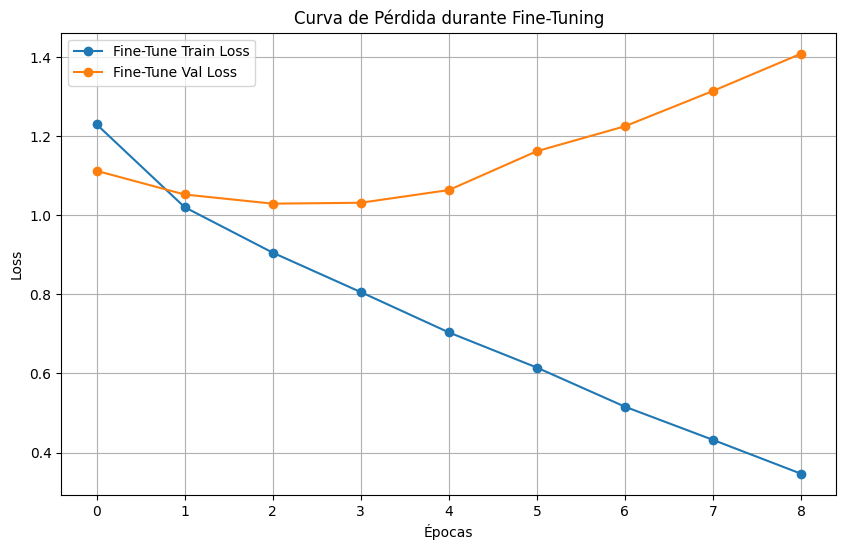

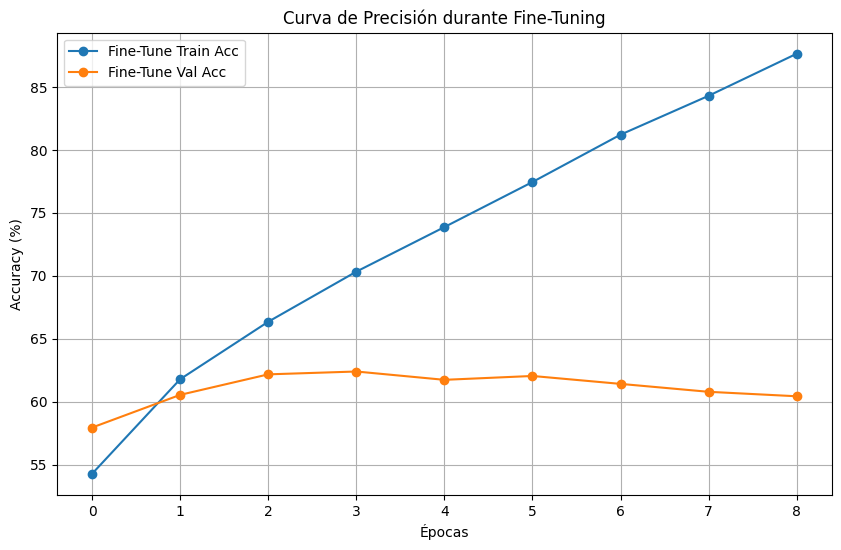

In [27]:
# Gráfica de Loss durante Fine-Tuning
plt.figure(figsize=(10, 6))
plt.plot(ft_train_loss_history, label='Fine-Tune Train Loss', marker='o')
plt.plot(ft_val_loss_history, label='Fine-Tune Val Loss', marker='o')
plt.title('Curva de Pérdida durante Fine-Tuning')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Gráfica de Accuracy durante Fine-Tuning
plt.figure(figsize=(10, 6))
plt.plot(ft_train_acc_history, label='Fine-Tune Train Acc', marker='o')
plt.plot(ft_val_acc_history, label='Fine-Tune Val Acc', marker='o')
plt.title('Curva de Precisión durante Fine-Tuning')
plt.xlabel('Épocas')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

## Evaluación y Métricas Adicionales (modelo fine tunning)

Tiempo total de inferencia: 58.65 segundos
Tiempo promedio por imagen: 0.0095 segundos


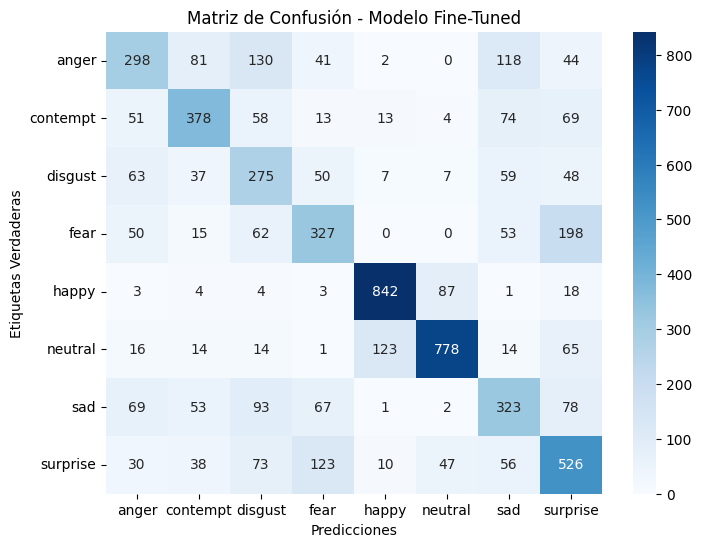

Reporte de Clasificación - Modelo Fine-Tuned:

              precision    recall  f1-score   support

       anger       0.51      0.42      0.46       714
    contempt       0.61      0.57      0.59       660
     disgust       0.39      0.50      0.44       546
        fear       0.52      0.46      0.49       705
       happy       0.84      0.88      0.86       962
     neutral       0.84      0.76      0.80      1025
         sad       0.46      0.47      0.47       686
    surprise       0.50      0.58      0.54       903

    accuracy                           0.60      6201
   macro avg       0.59      0.58      0.58      6201
weighted avg       0.61      0.60      0.61      6201



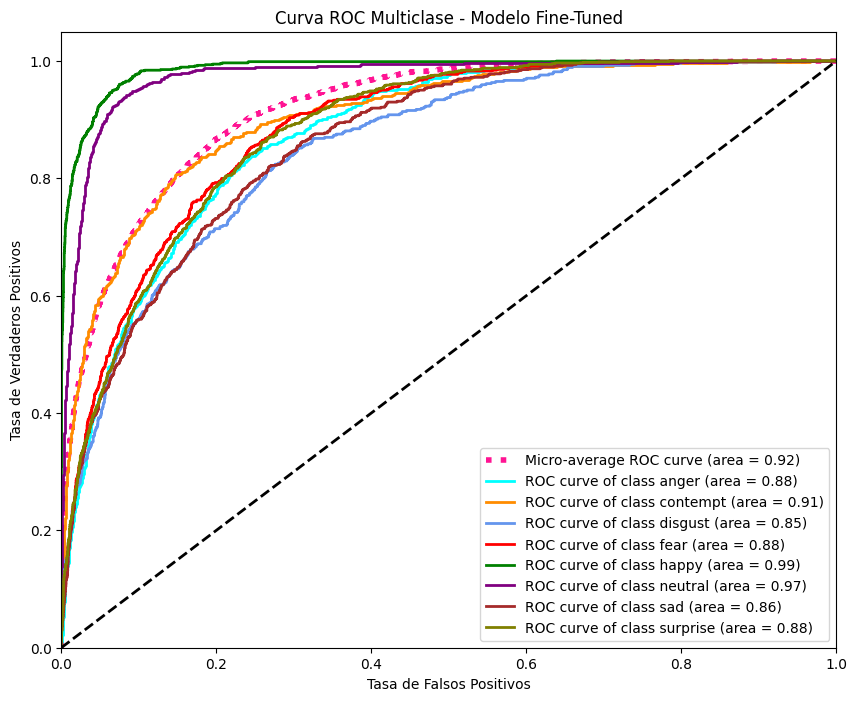

In [28]:
# Colocamos el modelo en modo evaluación (modelo tras fine-tuning)
model.eval()

# Acumulamos predicciones y etiquetas verdaderas del conjunto de validación
all_preds_ft = []
all_targets_ft = []
all_probs_ft = []  # Para la curva ROC

# start time
start_time = time.time()

with torch.no_grad():
    for inputs, targets in val_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)
        
        all_preds_ft.extend(preds.cpu().numpy())
        all_targets_ft.extend(targets.cpu().numpy())
        all_probs_ft.extend(probs.cpu().numpy())
# end time
end_time = time.time()
# Imprimimos el tiempo total de inferencia y el tempo promedio por imagen
print(f"Tiempo total de inferencia: {end_time - start_time:.2f} segundos")
print(f"Tiempo promedio por imagen: {(end_time - start_time) / len(val_loader.dataset):.4f} segundos")
# Matriz de Confusión
cm_ft = confusion_matrix(all_targets_ft, all_preds_ft)
plt.figure(figsize=(8,6))
sns.heatmap(cm_ft, annot=True, fmt='d', cmap="Blues",
            xticklabels=full_dataset.classes, yticklabels=full_dataset.classes)
plt.xlabel("Predicciones")
plt.ylabel("Etiquetas Verdaderas")
plt.title("Matriz de Confusión - Modelo Fine-Tuned")
plt.show()

# Reporte de Clasificación
print("Reporte de Clasificación - Modelo Fine-Tuned:\n")
print(classification_report(all_targets_ft, all_preds_ft, target_names=full_dataset.classes))

# Opcional: Curva ROC Multiclase para Modelo Fine-Tuned
all_probs_ft = np.array(all_probs_ft)
all_targets_ft = np.array(all_targets_ft)
y_true_bin_ft = label_binarize(all_targets_ft, classes=range(NUM_CLASSES))
n_classes = NUM_CLASSES

fpr_ft = dict()
tpr_ft = dict()
roc_auc_ft = dict()

for i in range(n_classes):
    fpr_ft[i], tpr_ft[i], _ = roc_curve(y_true_bin_ft[:, i], all_probs_ft[:, i])
    roc_auc_ft[i] = auc(fpr_ft[i], tpr_ft[i])

fpr_ft["micro"], tpr_ft["micro"], _ = roc_curve(y_true_bin_ft.ravel(), all_probs_ft.ravel())
roc_auc_ft["micro"] = auc(fpr_ft["micro"], tpr_ft["micro"])

plt.figure(figsize=(10,8))
plt.plot(fpr_ft["micro"], tpr_ft["micro"],
         label='Micro-average ROC curve (area = {0:0.2f})'.format(roc_auc_ft["micro"]),
         color='deeppink', linestyle=':', linewidth=4)
colors = ['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'purple', 'brown', 'olive', 'cyan']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr_ft[i], tpr_ft[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(full_dataset.classes[i], roc_auc_ft[i]))
plt.plot([0,1], [0,1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC Multiclase - Modelo Fine-Tuned')
plt.legend(loc="lower right")
plt.show()